In [2]:
import sys
cadEditorDir = "d:/DEV/CadEditor/CadEditor/"
sys.path.append(cadEditorDir)

import clr
clr.AddReference("CadEditor")
clr.AddReference("PluginVideoNes")

from PluginVideoNes import Video
from CadEditor import UtilsGDI
from System.Drawing import Bitmap
from System import Array, Byte
import array
from IPython.display import display, Image

In [3]:
romName = cadEditorDir + "/Addams Family, The (E) [!].nes"
with open(romName, "rb") as f:
    d = f.read()

In [4]:
video = Video()

In [5]:
def toDotNetArray(data):
    return  Array[Byte](array.array('c', data))

CHR_ADDR = 0x21010 #адрес банка видеопамяти для фона первого уровня
CHR_BANK_SIZE = 0x1000
chrData = d[CHR_ADDR:CHR_ADDR + CHR_BANK_SIZE]
chrData = toDotNetArray(chrData)

PAL_ADDR = 0x2e0d #адрес палитры
PAL_SIZE = 16
palData = d[PAL_ADDR:PAL_ADDR + PAL_SIZE]
palData = toDotNetArray(palData)

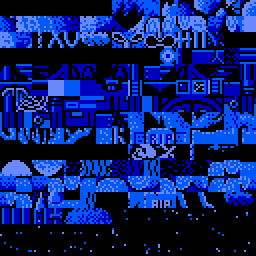

In [6]:
chrBitmap = video.makeImageRectangle(chrData, palData, 0, 2.0, True, False)
picPath = "D:/CadEditorPythonExamples/"
#сохраняем картинку в файл:
chrBitmap.Save(picPath+"chr0.png")
#отображаем её:
Image(filename=picPath+"chr0.png")

Отображение игровых блоков
---

Палитры описываются одним байтом на блок 4x4 тайла, по 2 бита на квадрат из 2x2 тайлов, описание слева-направо

In [7]:
def readPalMatrix():
    PAL_ADDRESS = 0xCCCC
    PAL_ROW_LEN = 64
    PAL_HEIGHT = 5
    pals = []
    for x in xrange(PAL_HEIGHT):
        rowBeginAddr = PAL_ADDRESS + x*PAL_ROW_LEN
        row = d[rowBeginAddr:rowBeginAddr+PAL_ROW_LEN]
        pals.append(row)
    #транспонируем строки и столбцы, чтобы экран описывался постолбцово, а не построчно, соотвественно тому, как описываются тайлы
    pals = [list(x) for x in zip(*pals)]
    return pals

palMatrix = readPalMatrix()

In [8]:
def makePalBitsForRow(pals, rowIndex):
    palBlocks = pals[rowIndex/4]
    palBits = []
    #
    if (rowIndex%4 < 2):
        for palBlockIndex in xrange(len(palBlocks)):
            palBlock = ord(palBlocks[palBlockIndex])
            palBits.append((palBlock>>0) & 0x3)
            palBits.append((palBlock>>0) & 0x3)
            palBits.append((palBlock>>4) & 0x3)
            palBits.append((palBlock>>4) & 0x3)
    else:
        for palBlockIndex in xrange(len(palBlocks)):
            palBlock = ord(palBlocks[palBlockIndex])
            palBits.append((palBlock>>2) & 0x3)
            palBits.append((palBlock>>2) & 0x3)
            palBits.append((palBlock>>6) & 0x3)
            palBits.append((palBlock>>6) & 0x3)
    return palBits

Уровень описывается индексами строк тайлов. Строки состоят из 20 тайлов в высоту

In [9]:
LEVEL_HEIGHT = 20
def makeColumnTiles(addr):
    ts = []
    for x in xrange(LEVEL_HEIGHT):
        tileIndex = ord(d[addr+x])
        ts.append(tileIndex)
    return ts

In [10]:
def makeColumnImage(ts, palBits):
    ti = []
    for x in xrange(LEVEL_HEIGHT):
        t = video.makeImage(ts[x], chrData, palData, palBits[x], 2.0, True, False)
        ti.append(t)
    return UtilsGDI.GlueImages(Array[Bitmap](ti),1,LEVEL_HEIGHT)

In [11]:
LINE_ADDR = 0xC282
LEVEL_WIDTH = 128
lineTiles = []
for l in xrange(LEVEL_WIDTH):
    ts = makeColumnTiles(LINE_ADDR + l*LEVEL_HEIGHT)
    lineTiles.append(ts)

In [12]:
for x in xrange(3):
    im = makeColumnImage(lineTiles[x], [0]*LEVEL_HEIGHT)
    im.Save(picPath+"line%d.png"%x)
    display(Image(filename=picPath+"line%d.png"%x))

In [13]:
def makeScreen():
    LINES_INDEXES_ADDR = 0xC0A8
    LINES_COUNT = 256
    indexes = d[LINES_INDEXES_ADDR:LINES_INDEXES_ADDR+LINES_COUNT]
    indexes = map(ord, indexes)
    linesPics = []
    for x in xrange(LINES_COUNT):
        palBits = makePalBitsForRow(palMatrix,x)
        #lineImage = makeColumnImage([0x14]*20, palBits)
        lineImage = makeColumnImage(lineTiles[indexes[x]], palBits)
        linesPics.append(lineImage)
    return UtilsGDI.GlueImages(Array[Bitmap](linesPics), LINES_COUNT,1)

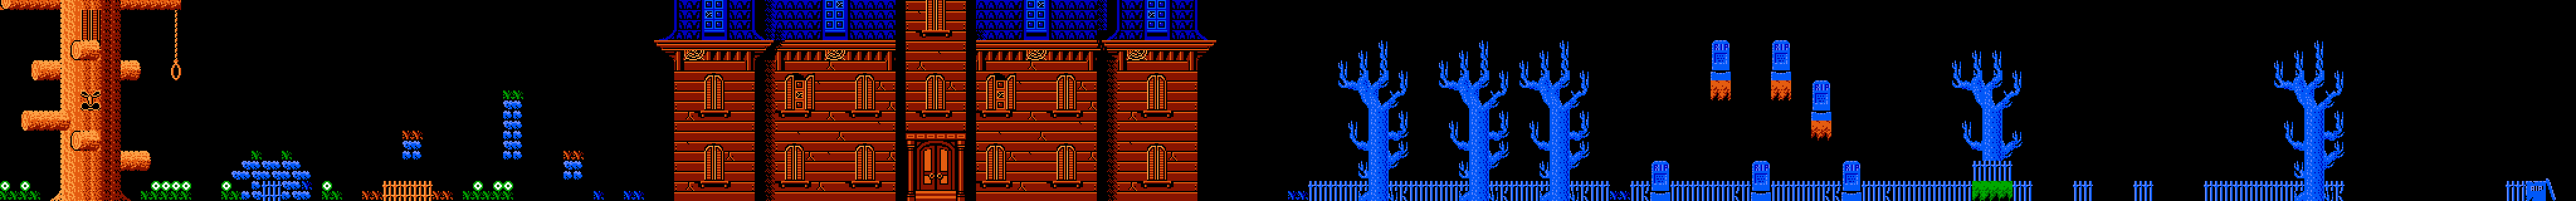

In [14]:
scr = makeScreen()
scr.Save(picPath+"scr0.png")
Image(filename=picPath+"scr0.png")